In [131]:
import numpy as np
import pandas as pd

data_path = 'input/bike-sharing-demand/'

# 데이터 불러오기
# read_csv에서 parse_dates=["datetime"] 옵션을 주면 datetime 피처가 datetime64[ns] 타입으로 자동 변환됨
train = pd.read_csv(data_path + 'train.csv', parse_dates=["datetime"])
test = pd.read_csv(data_path + 'test.csv', parse_dates=["datetime"])
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [132]:
# 데이터의 크기를 확인
print(train.shape, test.shape)

(10886, 12) (6493, 9)


In [133]:
# 피처 엔지니어링

# datetime 피처를 연, 월, 일, 시간, 분, 초로 분리
for dataset in [train, test]:
    dataset['year'] = dataset['datetime'].dt.year
    dataset['month'] = dataset['datetime'].dt.month
    dataset['day'] = dataset['datetime'].dt.day
    dataset['hour'] = dataset['datetime'].dt.hour
    dataset['minute'] = dataset['datetime'].dt.minute
    dataset['second'] = dataset['datetime'].dt.second
    dataset['dayofweek'] = dataset['datetime'].dt.dayofweek

In [134]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


### EDA

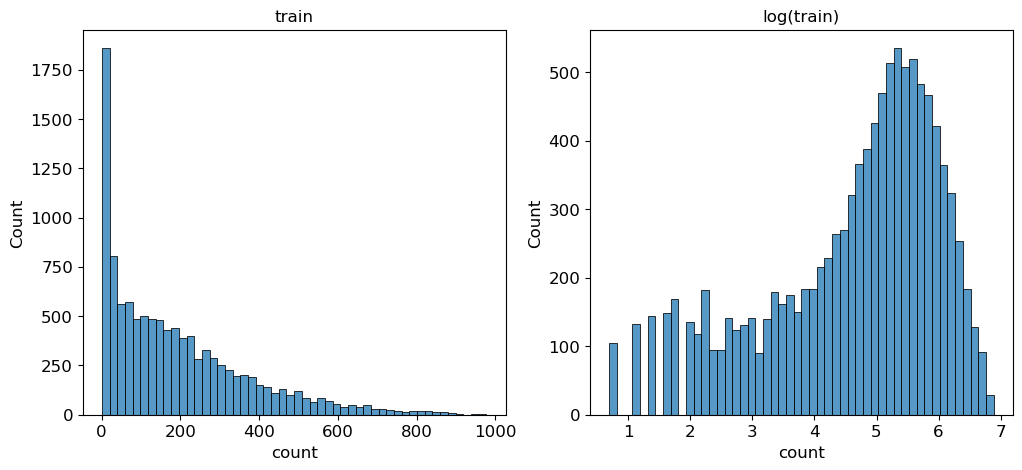

In [135]:
# train 데이터의 count 피처를 로그 변환한 결과를 시각화
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.histplot(train['count'], bins=50, ax=ax1)
ax1.set(title='train')
sns.histplot(np.log1p(train['count']), bins=50, ax=ax2)
ax2.set(title='log(train)')
plt.show()

count 피처의 분포가 왼쪽으로 치우쳐 있으므로 로그 변환을 통해 정규 분포에 가깝게 만들어줌

[Text(0.5, 1.0, 'Rantal Count by Season')]

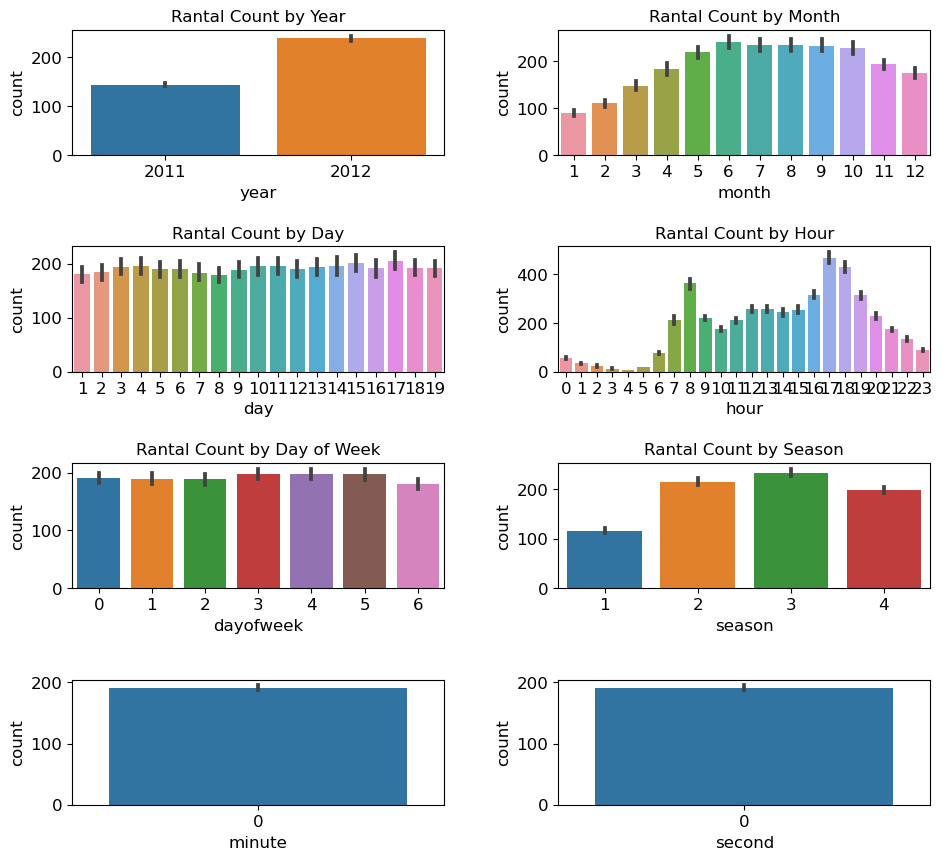

In [136]:
fig, axis = plt.subplots(nrows=4, ncols=2)
plt.tight_layout()

plt.rcParams['font.size'] = 12 # 폰트 크기 설정
plt.rcParams['axes.titlesize'] = 12 # 타이틀 크기 설정
fig.set_size_inches(10, 9) # 사이즈 설정

# 연도별 대여량
sns.barplot(data=train, x='year', y='count', ax=axis[0][0])
# 월별 대여량
sns.barplot(data=train, x='month', y='count', ax=axis[0][1])
# 일별 대여량
sns.barplot(data=train, x='day', y='count', ax=axis[1][0])
# 시간별 대여량
sns.barplot(data=train, x='hour', y='count', ax=axis[1][1])
# 요일별 대여량
sns.barplot(data=train, x='dayofweek', y='count', ax=axis[2][0])
# 계절별 대여량
sns.barplot(data=train, x='season', y='count', ax=axis[2][1])
# 분별 대여량
sns.barplot(data=train, x='minute', y='count', ax=axis[3][0])
# 초별 대여량
sns.barplot(data=train, x='second', y='count', ax=axis[3][1])

# 타이틀 추가
axis[0][0].set(title='Rantal Count by Year')
axis[0][1].set(title='Rantal Count by Month')
axis[1][0].set(title='Rantal Count by Day')
axis[1][1].set(title='Rantal Count by Hour')
axis[2][0].set(title='Rantal Count by Day of Week')
axis[2][1].set(title='Rantal Count by Season')


1. 2011년보다 2012년에 대여량이 많음
2. 날씨가 추울 때 보다 따뜻해 질 때 대여량이 많아짐
3. 일별 대여량에는 차이가 거의 없고 train 데이터에는 19일까지만 있으므로 day feature는 제거
4. 8시, 17시에 대여량이 높은 것으로 봐서 출근, 퇴근 시간에 많이 사용하는 것으로 예상됨
5. 6(토)보다 5(금)에 대여량이 많음
6. 1(봄)보다 3(가을)에 대여량이 많음
7. 분, 초 feature는 모두 0이므로 의미 없음

<Axes: xlabel='workingday', ylabel='count'>

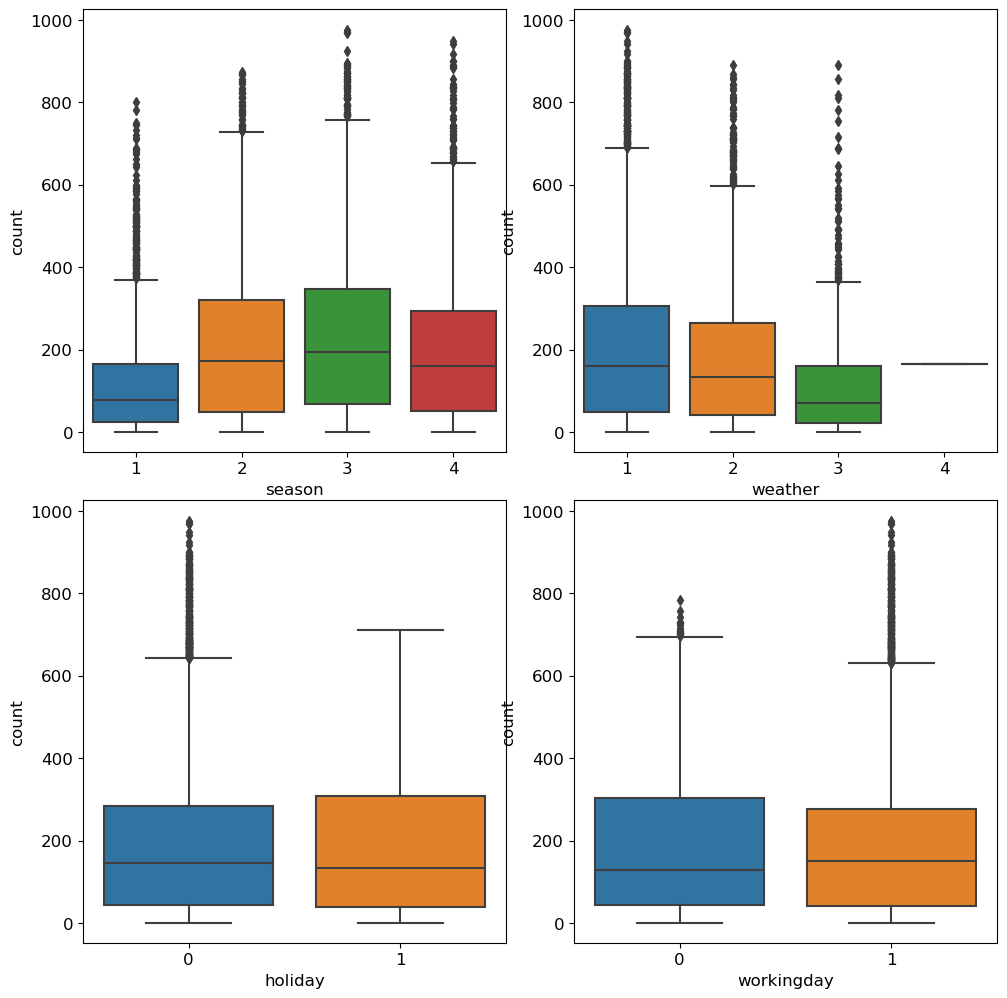

In [137]:
# 2행 2열의 그래프를 그리기 위해 2개의 행렬을 생성
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
fig.tight_layout()

# 계절, 날씨, 휴일, 작업일에 따른 대여량
sns.boxplot(data=train, x='season', y='count', ax=axis[0][0])
sns.boxplot(data=train, x='weather', y='count', ax=axis[0][1])
sns.boxplot(data=train, x='holiday', y='count', ax=axis[1][0])
sns.boxplot(data=train, x='workingday', y='count', ax=axis[1][1])

<Axes: xlabel='hour', ylabel='count'>

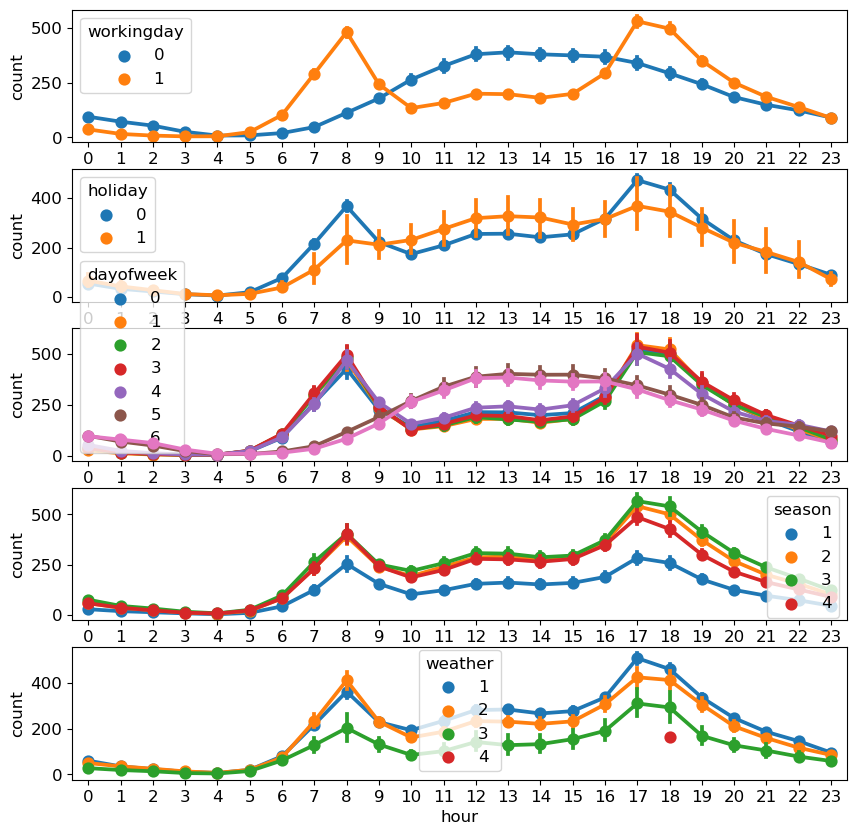

In [138]:
# 5행 1열 그래프를 그리기 위해 5개의 행렬을 생성
fig, axis = plt.subplots(nrows=5, ncols=1)
fig.set_size_inches(10, 10)

# 근무일, 공휴일, 요일, 계절, 날씨에 따른 대여량
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=axis[0])
sns.pointplot(data=train, x='hour', y='count', hue='holiday', ax=axis[1])
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek', ax=axis[2])
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=axis[3])
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=axis[4])

1. 업무일에는 출퇴근 시간에 대여량이 많고, 휴일에는 오후에 대여량이 많음
2. 봄에 대여량이 적고 여름, 가을, 겨울에 대여량이 많음
3. 날씨가 좋을수록 대여량이 많으나 4번(폭우, 폭설)의 경우에 일부 데이터가 존재함. 이상치로 판단하여 제거 필요

<Axes: >

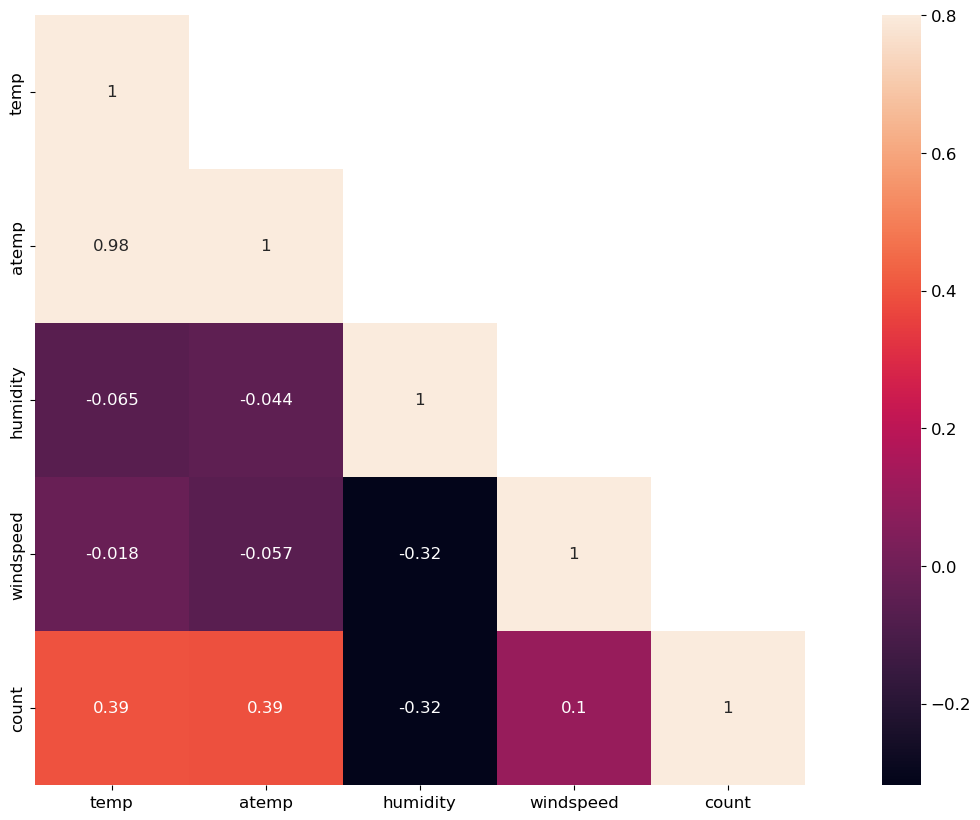

In [139]:
# 피처간 상관관계를 시각화
corrMatt = train[['temp', 'atemp', 'humidity', 'windspeed', 'count']]
corrMatt = corrMatt.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False # 상삼각행렬만 표시
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

1. 온도와 체감온도는 상관관계가 높으므로 하나의 피처만 사용
2. 습도와 풍속은 상관관계가 낮으므로 두 피처 모두 사용

<Axes: xlabel='windspeed', ylabel='count'>

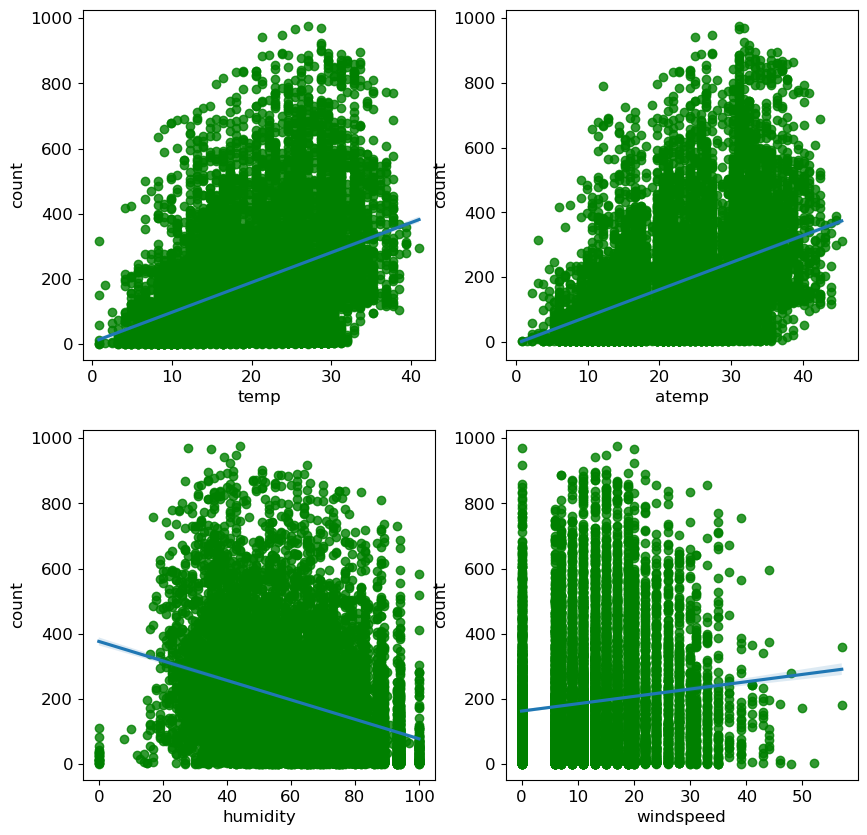

In [140]:
# 2행 2열의 그래프를 그리기 위해 2개의 행렬을 생성
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)

# 온도, 체감온도, 습도, 풍속에 따른 대여량 산점도 그래프
sns.regplot(x='temp', y='count', data=train, ax=axis[0][0], scatter_kws={'color':'green'})
sns.regplot(x='atemp', y='count', data=train, ax=axis[0][1], scatter_kws={'color':'green'})
sns.regplot(x='humidity', y='count', data=train, ax=axis[1][0], scatter_kws={'color':'green'})
sns.regplot(x='windspeed', y='count', data=train, ax=axis[1][1], scatter_kws={'color':'green'})

1. 온도와 체감 온도가 높을 수록 대여량이 많음
2. 습도가 낮을 수록 대여량이 많음
3. 풍속의 경우 많은 데이터가 0으로 기록되어 있음. 결측치로 판단됨.

## Baseline

In [141]:
# 훈련 데이터 중 wather가 4인 데이터를 제거
train = train[train['weather'] != 4]

In [142]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [143]:
# 훈련 데이터와 테스트 데이터 중 필요없는 피처를 제거
all_data = pd.concat([train, test], axis=0, ignore_index=True)

# 훈련 데이터와 테스트 데이터를 합친 데이터에서 필요없는 피처를 제거
to_drop = ['datetime', 'workingday', 'minute', 'second', 'casual', 'registered', 'month', 'day', 'dayofweek']
all_data.drop(to_drop, axis=1, inplace=True)

# 훈련 데이터와 테스트 데이터를 다시 분리
train = all_data[:train.shape[0]] # 훈련 데이터의 행 개수만큼 슬라이싱
test = all_data[train.shape[0]:]


In [150]:
test

,season,holiday,weather,temp,atemp,humidity,windspeed,count,year,hour
10885,1,0,1,10.66,11.365,56,26.0027,NaN,2011,0
10886,1,0,1,10.66,13.635,56,0.0000,NaN,2011,1
10887,1,0,1,10.66,13.635,56,0.0000,NaN,2011,2
10888,1,0,1,10.66,12.880,56,11.0014,NaN,2011,3
10889,1,0,1,10.66,12.880,56,11.0014,NaN,2011,4
...,...,...,...,...,...,...,...,...,...,...
17373,1,0,2,10.66,12.880,60,11.0014,NaN,2012,19
17374,1,0,2,10.66,12.880,60,11.0014,NaN,2012,20
17375,1,0,1,10.66,12.880,60,11.0014,NaN,2012,21
17376,1,0,1,10.66,13.635,56,8.9981,NaN,2012,22


In [151]:
# 훈련 데이터와 테스트 데이터를 정의
X_train = train.drop('count', axis=1)
y_train = train['count']
X_test = test.drop('count', axis=1)
y_test = test['count']

In [152]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()

log_y = np.log(y_train)
linear_reg.fit(X_train, log_y)

LinearRegression()

In [153]:
from sklearn.metrics import mean_squared_log_error

preds = linear_reg.predict(X_train)
print('RMSLE Value For Linear Regression: ', mean_squared_log_error(np.exp(log_y), np.exp(preds), squared=False))

RMSLE Value For Linear Regression:  1.020999870452562


In [156]:
# 예측 및 제출
pred_y = linear_reg.predict(X_test)
submission['count'] = np.exp(pred_y)
submission.to_csv('output/bike-sharing-demand/submission.csv', index=False)